## K-Means Clustering for structure identification

In this notebook the k-means clustering algorithm from scikit learn was tested with regrads to deriving a TSK controller from a dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

Documentation K-Means:
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* https://scikit-learn.org/stable/modules/clustering.html#k-means

Multi-linear regression:
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [2]:
train_data = pd.read_csv("dataset/matlab_1_train.csv")

In [3]:
n_fuzzy_sets = 3
outer_bound_factor = 1
inner_bound_factor = 0.3

In [4]:
X = train_data.iloc[:, 1:].to_numpy()
X

array([[ 5.450000e-02,  7.969000e+02,  6.687490e+02, ...,  1.867500e+01,
         2.539096e+01,  3.575400e+00],
       [ 8.182000e-01,  1.598000e+02,  6.671610e+02, ...,  1.976250e+01,
         3.445457e+01,  5.274200e+00],
       [-1.525000e-01,  5.601000e+02,  4.445890e+02, ...,  3.010000e+01,
         4.191501e+01,  1.808905e+01],
       ...,
       [ 4.170000e-02,  6.322000e+02,  6.426440e+02, ...,  2.240000e+01,
         3.363775e+01,  8.526920e+00],
       [-5.328000e-01,  2.882000e+02,  5.303860e+02, ...,  1.812857e+01,
         3.001427e+01,  8.121220e+00],
       [-2.560000e-01,  6.322000e+02,  6.426440e+02, ...,  2.240000e+01,
         3.363775e+01,  8.526920e+00]])

In [5]:
cluster_obj = KMeans(n_clusters=10, n_init=10)
cluster_fit = cluster_obj.fit(X)
merged_data = pd.merge(train_data.iloc[:, 1:], pd.DataFrame({"Subcluster_number" : cluster_fit.labels_}), left_index=True, right_index=True)

In [6]:
merged_data

,Relative_yield_change,P,E,PB,Tave,Tmax,Tmin,Subcluster_number
0,0.0545,796.9,668.749,128.151,18.67500,25.39096,3.57540,7
1,0.8182,159.8,667.161,-507.361,19.76250,34.45457,5.27420,2
2,-0.1525,560.1,444.589,115.511,30.10000,41.91501,18.08905,0
3,-0.1485,502.5,510.423,-7.923,18.16667,25.69895,6.81734,0
4,-0.4000,681.0,605.264,75.736,23.83333,34.08730,12.49785,7
...,...,...,...,...,...,...,...,...
1024,0.0233,558.3,512.182,46.118,24.42500,26.67880,17.19974,0
1025,-0.0259,404.1,543.628,-139.528,20.65000,30.93442,7.87919,4
1026,0.0417,632.2,642.644,-10.444,22.40000,33.63775,8.52692,7
1027,-0.5328,288.2,530.386,-242.186,18.12857,30.01427,8.12122,4


In [7]:
merged_data.iloc[:, 1:-1].columns

Index(['P', 'E', 'PB', 'Tave', 'Tmax', 'Tmin'], dtype='object')

In [8]:
feature_sets = []
subclusters = []
mfs = []
clusters = {i : [] for i in np.unique(cluster_fit.labels_)}

for k in range(1, len(merged_data.iloc[:, 1:-1].columns)+1):
    raw_mfs = cluster_fit.cluster_centers_[:,k].reshape(-1, 1)
    # Reduce amount of mfs by clustering in one dimension
    reduced_mfs_middle = KMeans(n_clusters=n_fuzzy_sets, n_init=5).fit(raw_mfs)
    feature_sets.append(reduced_mfs_middle.cluster_centers_.ravel())
    subcluster_in_clusters = [[] for i in np.unique(reduced_mfs_middle.labels_)]
    for subcluster_number in range(len(raw_mfs)):
        cur_cluster_number = reduced_mfs_middle.labels_[subcluster_number]
        clusters[subcluster_number].append(cur_cluster_number)
        subcluster_in_clusters[cur_cluster_number].append(subcluster_number)
    
    cur_mfs = []
    for cluster, subclusters in enumerate(subcluster_in_clusters):
        # For each cluster in subcluster calculate std for current feature
        cur_std = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].std()
        cur_min = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].min()
        cur_max = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].max()
        cur_center = feature_sets[k-1][cluster]
        cur_mfs.append([cur_center - (abs(cur_center - cur_min)), cur_center - cur_std*inner_bound_factor, cur_center + cur_std*inner_bound_factor, cur_center + (abs(cur_center - cur_max))])

    mfs.append(cur_mfs)

In [9]:
mfs

[[[-42.0, 252.34637961979504, 315.1047471818098, 487.2],
  [841.9, 1058.2764760034947, 1171.7983859987921, 1574.3],
  [378.2, 595.3118833643776, 657.5120201128046, 861.9000053]],
 [[249.642, 445.217249011489, 481.73282451527393, 629.7],
  [576.611, 695.1949550266226, 747.460550919135, 1020.887],
  [381.209, 544.1374438849023, 586.9888947349316, 810.192]],
 [[-26.971000000000004, 237.95312087784538, 316.74293246811425, 606.422],
  [-741.692, -212.55598394071737, -123.80643092075562, 133.236],
  [746.402, 849.5004549558398, 899.7851164727313, 957.391]],
 [[6.914290000000001, 18.599649965298568, 21.547842316846015, 31.78],
  [15.71429, 22.072359606446447, 25.437979356529745, 30.05],
  [8.02857, 16.10093223714176, 19.38394720609892, 31.72]],
 [[20.50167, 29.09899499731371, 31.616662959050046, 41.91501],
  [18.50414, 26.975405663058396, 29.842983374628005, 41.81672],
  [26.96951, 31.272680292917997, 34.45297945041534, 40.53674]],
 [[-5.421050000000001, 8.222351348974245, 12.25138031734606, 

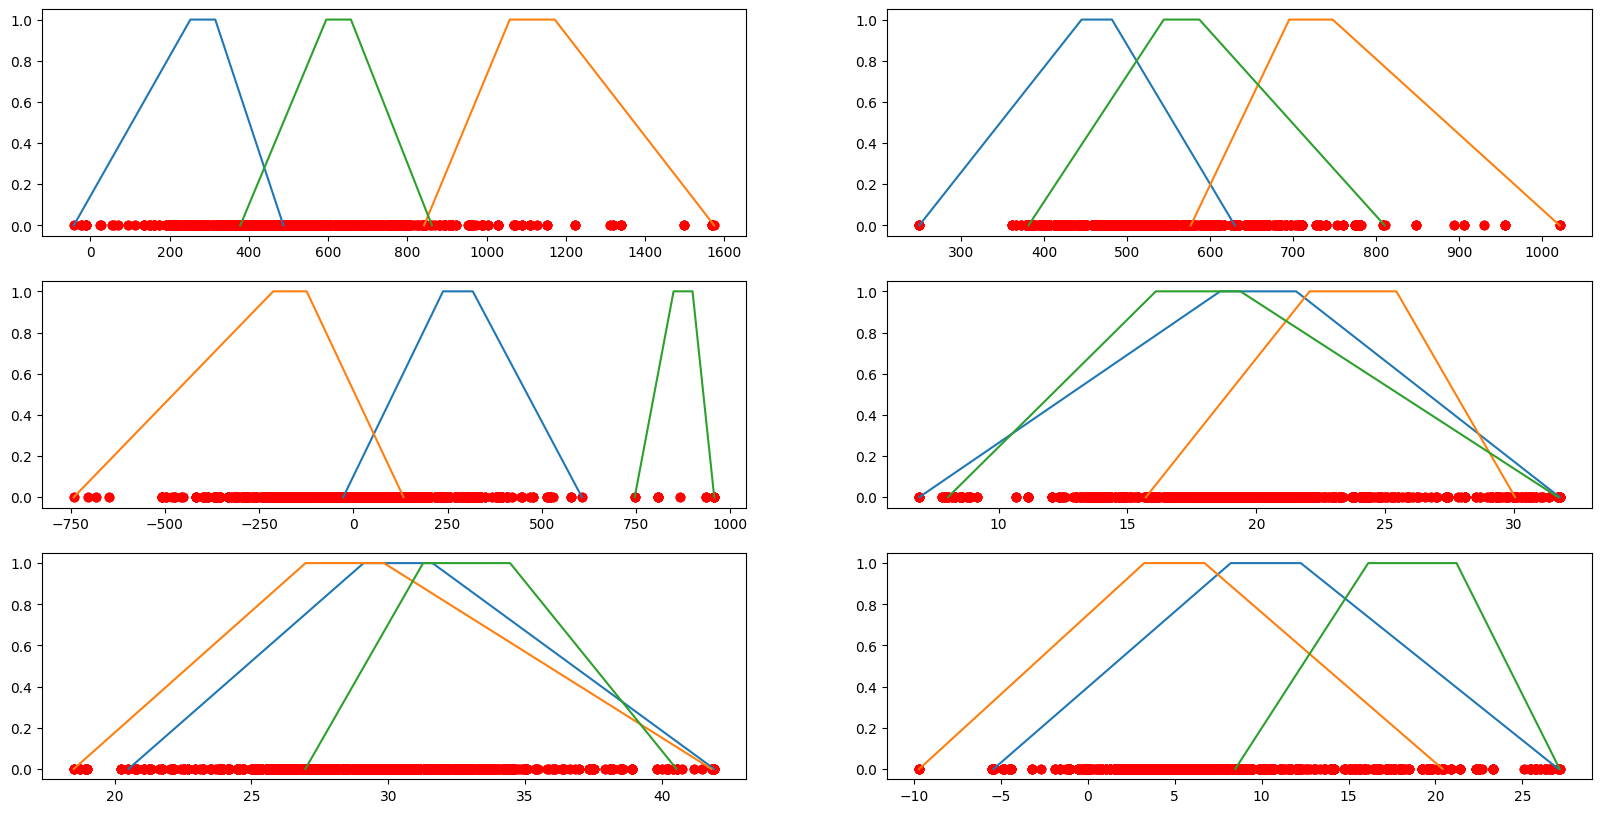

In [10]:
fig, ax = plt.subplots(3,2, figsize=(20, 10))
for plot in range(0,6):
    for mf in mfs[plot]:
        ax[int(plot / 2)][plot % 2].plot(mf, [0,1,1,0])
        ax[int(plot / 2)][plot % 2].scatter(merged_data.iloc[:, plot+1], np.zeros(merged_data.shape[0]), c="r")

plt.show()

In [11]:
feature_sets

[array([ 283.7255634 , 1115.037431  ,  626.41195174]),
 array([463.47503676, 721.32775297, 565.56316931]),
 array([ 277.34802667, -168.18120743,  874.64278571]),
 array([20.07374614, 23.75516948, 17.74243972]),
 array([30.35782898, 28.40919452, 32.86282987]),
 array([10.23686583,  4.98246054, 18.67120786])]

In [12]:
clusters

{0: [2, 0, 1, 0, 0, 0],
 1: [1, 0, 0, 1, 2, 0],
 2: [0, 2, 1, 2, 0, 1],
 3: [2, 1, 1, 0, 1, 0],
 4: [0, 2, 1, 0, 0, 1],
 5: [1, 2, 2, 1, 0, 2],
 6: [2, 0, 0, 0, 0, 0],
 7: [2, 2, 0, 0, 1, 0],
 8: [0, 0, 1, 2, 1, 1],
 9: [1, 1, 0, 0, 1, 0]}

In [13]:
test_mfs = cluster_fit.cluster_centers_[:,0].reshape(-1, 1)
np.concatenate((test_mfs, np.unique(cluster_fit.labels_).reshape(-1, 1)), axis=1)

array([[-0.04952786,  0.        ],
       [-0.03420833,  1.        ],
       [ 0.08741505,  2.        ],
       [ 0.10864697,  3.        ],
       [ 0.05555523,  4.        ],
       [-0.04202857,  5.        ],
       [-0.05946952,  6.        ],
       [ 0.06885139,  7.        ],
       [ 0.01991277,  8.        ],
       [-0.00970909,  9.        ]])

Here the consequents are calculated by LinearRegression

In [14]:
subclusters = merged_data["Subcluster_number"].unique()
r2_scores = []
consequent_params = []
intercepts = []
for subcluster in subclusters:
    cur_X = merged_data[merged_data["Subcluster_number"] == subcluster].iloc[:, 1:-1]
    cur_Y = merged_data[merged_data["Subcluster_number"] == subcluster].iloc[:, 0]
    cur_linear = LinearRegression().fit(cur_X, cur_Y)
    consequent_params.append(cur_linear.coef_)
    intercepts.append(cur_linear.intercept_)
    r2_scores.append(cur_linear.score(cur_X, cur_Y))


In [29]:
merged_data.iloc[:,1:-1]

,P,E,PB,Tave,Tmax,Tmin
0,796.9,668.749,128.151,18.67500,25.39096,3.57540
1,159.8,667.161,-507.361,19.76250,34.45457,5.27420
2,560.1,444.589,115.511,30.10000,41.91501,18.08905
3,502.5,510.423,-7.923,18.16667,25.69895,6.81734
4,681.0,605.264,75.736,23.83333,34.08730,12.49785
...,...,...,...,...,...,...
1024,558.3,512.182,46.118,24.42500,26.67880,17.19974
1025,404.1,543.628,-139.528,20.65000,30.93442,7.87919
1026,632.2,642.644,-10.444,22.40000,33.63775,8.52692
1027,288.2,530.386,-242.186,18.12857,30.01427,8.12122


In [16]:
r2_scores

[0.11834811428263514,
 0.13428386325360742,
 0.15905001588189105,
 0.13326550015910232,
 0.3844126841594627,
 0.1289081188788641,
 0.22480043529643612,
 0.21003846635036683,
 0.5488588021789238,
 0.670140101938147]

In [17]:
consequent_params

[array([-8.19828824e+02,  8.19830075e+02,  8.19829584e+02,  4.90194564e-02,
        -3.86458507e-02, -2.95158099e-03]),
 array([ 2.00124012e+11, -2.00124012e+11, -2.00124012e+11,  3.72333527e-02,
         8.86058807e-03, -1.17092133e-02]),
 array([-5.18848904e+01,  5.18843162e+01,  5.18844774e+01, -3.41503815e-03,
         2.59020624e-02, -4.01267908e-03]),
 array([ 2.75909339e+01, -2.75907273e+01, -2.75920086e+01, -4.84731630e-02,
         6.05525656e-02,  6.11555446e-03]),
 array([ 2.97159810e+02, -2.97160446e+02, -2.97160014e+02,  5.63881580e-02,
        -6.69250976e-02, -7.24021804e-03]),
 array([-1.42449633e+03,  1.42449471e+03,  1.42449147e+03,  9.16777816e-02,
        -3.83707403e-02, -5.78797869e-02]),
 array([ 5.78653899e+01, -5.78661884e+01, -5.78668389e+01,  5.92515088e-02,
        -3.61072515e-03, -2.02924223e-02]),
 array([-3.91214729e+01,  3.91213063e+01,  3.91212449e+01, -6.50034465e-03,
         2.02167768e-02, -4.68015754e-03]),
 array([-2.17883036e+03,  2.17883334e+03

Prepare the mf representation

In [18]:
rows = []
feature_names = merged_data.iloc[:, 1:-1].columns
for i, feature in enumerate(mfs):
    for j, mf in enumerate(feature):
        rows.append([i, feature_names[i], j, mf[0], mf[1], mf[2], mf[3]])

fuzzy_set_table = pd.DataFrame(rows, columns=["feature_id", "feature_name", "set_id", "a", "b", "c", "d"])


In [19]:
rows = []
for rule_number, rule in clusters.items():
    rows.append(np.concatenate((rule, consequent_params[rule_number], [intercepts[rule_number]], [r2_scores[rule_number]])))

rule_base = pd.DataFrame(rows, columns=np.concatenate((feature_names, ["p"+str(i) for i in range(len(feature_names))], ["r"], ["r2"])))

In [20]:
rule_base

,P,E,PB,Tave,Tmax,Tmin,p0,p1,p2,p3,p4,p5,r,r2
0,2.0,0.0,1.0,0.0,0.0,0.0,-8.198288e+02,8.198301e+02,8.198296e+02,4.901946e-02,-3.864585e-02,-2.951581e-03,-5.685217e-01,0.118348
1,1.0,0.0,0.0,1.0,2.0,0.0,2.001240e+11,-2.001240e+11,-2.001240e+11,3.723335e-02,8.860588e-03,-1.170921e-02,-2.314279e+00,0.134284
2,0.0,2.0,1.0,2.0,0.0,1.0,-5.188489e+01,5.188432e+01,5.188448e+01,-3.415038e-03,2.590206e-02,-4.012679e-03,-4.407587e-01,0.159050
3,2.0,1.0,1.0,0.0,1.0,0.0,2.759093e+01,-2.759073e+01,-2.759201e+01,-4.847316e-02,6.055257e-02,6.115554e-03,-1.171265e+00,0.133266
4,0.0,2.0,1.0,0.0,0.0,1.0,2.971598e+02,-2.971604e+02,-2.971600e+02,5.638816e-02,-6.692510e-02,-7.240218e-03,1.288163e+00,0.384413
5,1.0,2.0,2.0,1.0,0.0,2.0,-1.424496e+03,1.424495e+03,1.424491e+03,9.167778e-02,-3.837074e-02,-5.787979e-02,5.688040e-01,0.128908
6,2.0,0.0,0.0,0.0,0.0,0.0,5.786539e+01,-5.786619e+01,-5.786684e+01,5.925151e-02,-3.610725e-03,-2.029242e-02,-2.451555e-01,0.224800
7,2.0,2.0,0.0,0.0,1.0,0.0,-3.912147e+01,3.912131e+01,3.912124e+01,-6.500345e-03,2.021678e-02,-4.680158e-03,-3.911705e-01,0.210038
8,0.0,0.0,1.0,2.0,1.0,1.0,-2.178830e+03,2.178833e+03,2.178830e+03,-3.371419e-01,9.917052e-02,1.796127e-01,9.735992e-01,0.548859
9,1.0,1.0,0.0,0.0,1.0,0.0,6.457954e+10,-6.457926e+10,-6.457952e+10,-2.309732e+07,2.469831e+06,1.563933e+07,4.638793e+07,0.670140


In [21]:
train_data

,Unnamed: 0,Relative_yield_change,P,E,PB,Tave,Tmax,Tmin
0,1920,0.0545,796.9,668.749,128.151,18.67500,25.39096,3.57540
1,2944,0.8182,159.8,667.161,-507.361,19.76250,34.45457,5.27420
2,3263,-0.1525,560.1,444.589,115.511,30.10000,41.91501,18.08905
3,755,-0.1485,502.5,510.423,-7.923,18.16667,25.69895,6.81734
4,1353,-0.4000,681.0,605.264,75.736,23.83333,34.08730,12.49785
...,...,...,...,...,...,...,...,...
1024,2509,0.0233,558.3,512.182,46.118,24.42500,26.67880,17.19974
1025,4058,-0.0259,404.1,543.628,-139.528,20.65000,30.93442,7.87919
1026,3993,0.0417,632.2,642.644,-10.444,22.40000,33.63775,8.52692
1027,1715,-0.5328,288.2,530.386,-242.186,18.12857,30.01427,8.12122
